In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize, NonlinearConstraint, LinearConstraint
import math
import matplotlib.pyplot as plt
pi = math.pi

In [2]:
#Setup initial forward simulation
S_init = np.array([0, 0, pi/2])
U = np.array([1, -1/2])
P_init = np.array([np.concatenate((S_init, U), axis=None)])

#Forward iteration for P0 (semi-circle initial guess)
T_STEPS = 100
dt = 2*pi/T_STEPS
t_array = np.zeros(T_STEPS)
for i in range(T_STEPS):
    t_array[i] = i*dt

P0 = np.zeros((T_STEPS, 5))
P0[0] = P_init
for i in range(T_STEPS-1):
    Sdot = np.array([U[0]*math.cos(P0[i][2]), U[0]*math.sin(P0[i][2]), U[1]])*dt
    S_new = P0[i][0:3] + Sdot
    P_new = np.array([np.concatenate((S_new, U), axis=None)])
    P0[i+1] = P_new
#S0 = P0[:,0:3]
#S0 = S0.flatten()

#Initial reference trajectory (S_bar, unattainable)
S_bar = np.zeros((T_STEPS, 3))
for i in range(T_STEPS):
    S_bar[i] = np.array([4*(i*dt)/(2*pi), 0, pi/2])

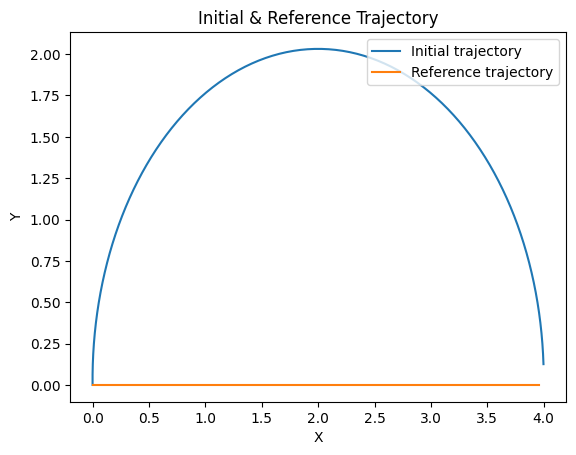

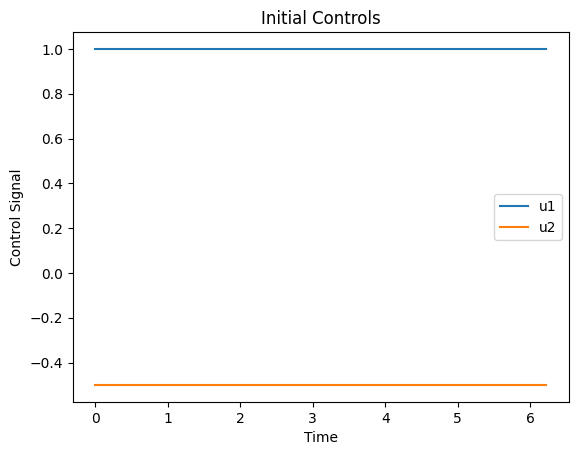

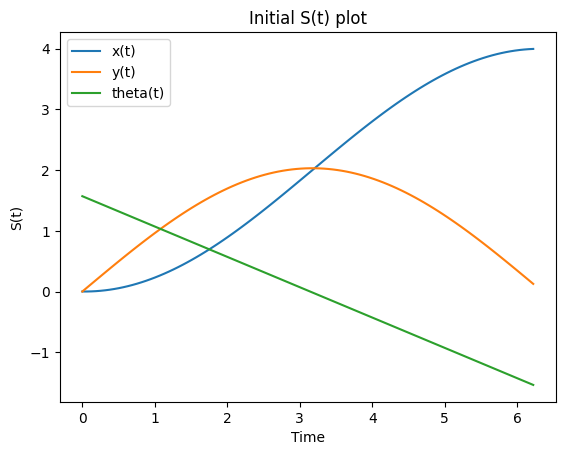

In [11]:
#Initial & Reference Trajectory Plot
plt.figure("Figure 1")
plt.plot(P0[:,0], P0[:,1], label = 'Initial trajectory')
plt.plot(S_bar[:,0], S_bar[:,1], label = 'Reference trajectory')
plt.title("Initial & Reference Trajectory")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc = 1)

#Initial Controls Plot
plt.figure("Figure 3")
plt.plot(t_array, P0[:,3], label = "u1")
plt.plot(t_array, P0[:,4], label = "u2")
plt.title("Initial Controls")
plt.xlabel("Time")
plt.ylabel("Control Signal")
plt.legend()

#Initial x(t) y(t) theta(t) plot
plt.figure("Figure 4")
plt.plot(t_array, P0[:,0], label = 'x(t)')
plt.plot(t_array, P0[:,1], label = 'y(t)')
plt.plot(t_array, P0[:,2], label = 'theta(t)')
plt.title("Initial S(t) plot")
plt.xlabel("Time")
plt.ylabel("S(t)")
plt.legend()

In [5]:
# Defining cost function
def J(P): # P is a (500,) input (essentially it takes in our intiial P0), returns a scalar from least squares that we want to minimize
    P = np.reshape(P, (100,5))
    P = P[:,0:3]
    P = P.flatten()
    P_bar = S_bar.flatten()
    error = P - P_bar
    cost = np.sum(np.square(error))
    #print(cost)
    return cost

def f(xu): # Helper for constraint, returns xdot, ydot, thetadot array
    xdot = math.cos(xu[2])*xu[3]
    ydot = math.sin(xu[2])*xu[3]
    thetadot = xu[4]
    return np.array([xdot, ydot, thetadot])

def c1(P): # P is a (500,) input that we will reshape, calculate constraint function s_i+1 - (s_i + dt*f(x,u)), sum up to return scalar (should be close to 0)
    total_sum = 0
    P = np.reshape(P, (100, 5))
    for i in range(T_STEPS-1):
        temp_s_array = P[i+1][0:3] - (P[i][0:3] + dt*f(P[i]))
        sum = np.sum(np.square(temp_s_array))
        total_sum = total_sum+sum
        #print(total_sum)
    return total_sum

nlc1 = NonlinearConstraint(c1, -0.0001, 0.0001)

def c2(P): # Secondary constraint function (just ensures our initial condition holds)
    P = np.reshape(P, (100,5))
    difference = P[0][0:3] - np.array([0, 0, pi/2])    
    return np.sum(np.square(difference))

nlc2 = NonlinearConstraint(c2, -0.0001, 0.0001)

In [6]:
# Solving optimization problem
P0_reshaped = P0.flatten()
result = minimize(J, P0_reshaped, method = 'SLSQP', constraints=[nlc1, nlc2], options = {"maxiter":10000})
optimized = result.x
#print(optimized)

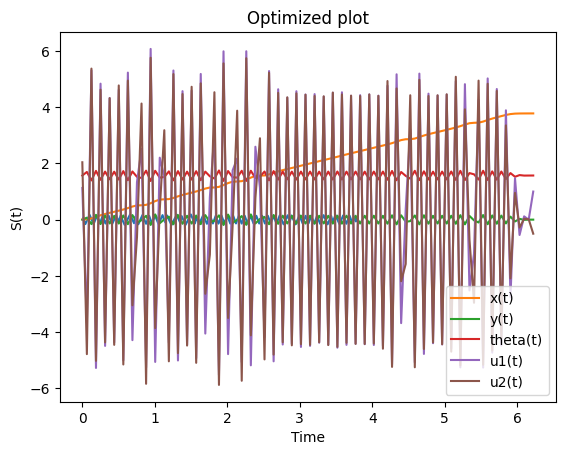

In [7]:
optimized = np.reshape(optimized, (100,5))
plt.plot(optimized[:,0], optimized[:,1])
plt.plot(t_array, optimized[:,0], label = 'x(t)')
plt.plot(t_array, optimized[:,1], label = 'y(t)')
plt.plot(t_array, optimized[:,2], label = 'theta(t)')
plt.plot(t_array, optimized[:,3], label = 'u1(t)')
plt.plot(t_array, optimized[:,4], label = 'u2(t)')
plt.title("Optimized plot")
plt.xlabel("Time")
plt.ylabel("S(t)")
plt.legend()


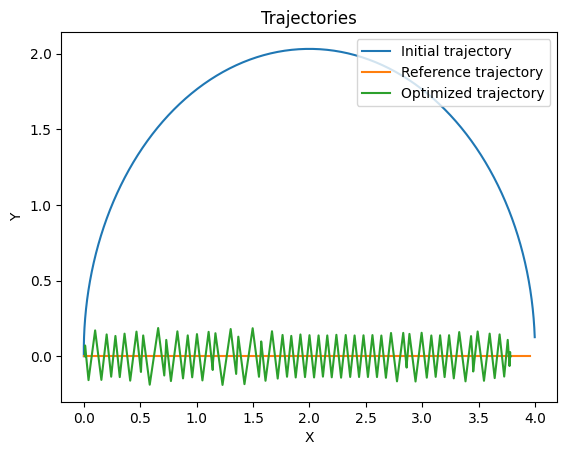

In [10]:
plt.plot(P0[:,0], P0[:,1], label = 'Initial trajectory')
plt.plot(S_bar[:,0], S_bar[:,1], label = 'Reference trajectory')
plt.plot(optimized[:,0], optimized[:,1], label = 'Optimized trajectory')
plt.title("Trajectories")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(loc = 1)


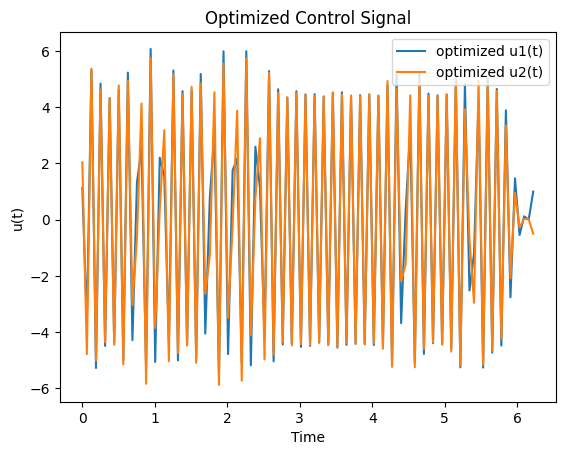

In [13]:
plt.plot(t_array, optimized[:,3], label = 'optimized u1(t)')
plt.plot(t_array, optimized[:,4], label = 'optimized u2(t)')
plt.title("Optimized Control Signal")
plt.xlabel("Time")
plt.ylabel("u(t)")
plt.legend(loc = 1)